# Import Necessary Libraries  
We begin by importing essential libraries for data manipulation and analysis.


In [1]:
# Import pandas for data handling and numpy for numerical operations
# matplotlib for plotting and seaborn for statistical data visualization
# # wordcloud for generating word clouds from text data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# Load Dataset  
Let's load the dataset that contains Airbnb listings. We'll first check the structure and preview the data.


In [2]:
# Load data
df = pd.read_csv("Dataset/listings.csv")

# Show structure
print("Shape:", df.shape)
df.head()
df.info()

Shape: (3818, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   o

In [3]:
# Display all column names for reference
pd.set_option('display.max_columns', None)
print(*df.columns.tolist(), sep="\n")


id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_re

# Data Cleaning  
We will now clean the dataset by handling missing values and removing unnecessary columns.

In [4]:
# Select 35 Relevant Columns
cols_to_keep = [
    'id', 'name', 'host_id', 'host_name', 'host_since', 'host_is_superhost',
    'host_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude',
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
    'availability_30', 'availability_365', 'number_of_reviews',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'instant_bookable', 'cancellation_policy',
    'reviews_per_month', 'description', 'neighborhood_overview'
]

df = df[cols_to_keep].copy()


In [5]:
# Clean Price Column
# Remove $ and commas, then convert to float
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)



In [6]:
# Check null values
df.isnull().sum().sort_values(ascending=False)


neighborhood_overview          1032
review_scores_checkin           658
review_scores_accuracy          658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
reviews_per_month               627
bathrooms                        16
bedrooms                          6
host_is_superhost                 2
host_listings_count               2
host_since                        2
host_name                         2
beds                              1
property_type                     1
id                                0
name                              0
host_id                           0
price                             0
amenities                         0
room_type                         0
accommodates                      0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
minimum_nights              

In [7]:
# Fill Null Values

# Fill description and neighborhood text columns
df['description'] = df['description'].fillna("No description")
df['neighborhood_overview'] = df['neighborhood_overview'].fillna("No info")

# Convert review score columns to numeric and fill with median
review_cols = [col for col in df.columns if 'review_scores' in col]
for col in review_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

# Fill numerical columns with median
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['beds'] = df['beds'].fillna(df['beds'].median())

# Fill reviews_per_month with 0 if missing (means no reviews)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


In [8]:
# Convert Dates
# Convert 'host_since' to datetime

df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

In [9]:
# Clean Bathrooms Column
# Ensure bathrooms is float and fill missing

df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())

In [10]:
# Standardize Booleans and Text Fields
# Use replace to avoid future warnings

# Boolean fields – use replace to avoid future warnings
df['host_is_superhost'] = df['host_is_superhost'].replace({np.nan: False}).astype(bool)
df['instant_bookable'] = df['instant_bookable'].replace({np.nan: False}).astype(bool)

# Fill other missing values
df['host_name'] = df['host_name'].fillna("Unknown")
df['host_listings_count'] = df['host_listings_count'].fillna(df['host_listings_count'].median())
df['property_type'] = df['property_type'].fillna(df['property_type'].mode()[0])

# Format text fields
df['cancellation_policy'] = df['cancellation_policy'].str.replace('_', ' ').str.title()
df['room_type'] = df['room_type'].str.title()
df['property_type'] = df['property_type'].str.title()


In [11]:
# Feature Engineering

# Average review score across all sub-score columns
review_cols = [col for col in df.columns if 'review_scores' in col]
df['review_score_avg'] = df[review_cols].mean(axis=1)

# Host tenure in days since joining Airbnb
df['host_tenure_days'] = (pd.Timestamp.today() - df['host_since']).dt.days


In [12]:
# Remove duplicates and Reset index

df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Final Check  
Before moving on, let’s inspect the cleaned dataset and its summary statistics.

In [13]:
# Create a separator line for section headers (80 characters wide)
line = "=" * 80

In [14]:
# Print shape of the dataset after all cleaning steps
print(line)
print("Final Shape After Cleaning".center(80))
print(line)
print("Shape:", df.shape, "\n")


                           Final Shape After Cleaning                           
Shape: (3818, 37) 



In [15]:
# Display concise summary of the dataset including non-null counts and data types
print(line)
print("DataFrame Info".center(80))
print(line)
df.info()
print()


                                 DataFrame Info                                 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           3818 non-null   int64         
 1   name                         3818 non-null   object        
 2   host_id                      3818 non-null   int64         
 3   host_name                    3818 non-null   object        
 4   host_since                   3816 non-null   datetime64[ns]
 5   host_is_superhost            3818 non-null   bool          
 6   host_listings_count          3818 non-null   float64       
 7   neighbourhood_cleansed       3818 non-null   object        
 8   latitude                     3818 non-null   float64       
 9   longitude                    3818 non-null   float64       
 10  property_type              

In [16]:
# Show descriptive statistics for numerical and categorical columns
print(line)
print("Descriptive Statistics".center(80))
print(line)
print(df.describe(include='all'), "\n")


                             Descriptive Statistics                             
                  id                    name       host_id host_name  \
count   3.818000e+03                    3818  3.818000e+03      3818   
unique           NaN                    3792           NaN      1467   
top              NaN  Capitol Hill Apartment           NaN    Andrew   
freq             NaN                       3           NaN        56   
mean    5.550111e+06                     NaN  1.578556e+07       NaN   
min     3.335000e+03                     NaN  4.193000e+03       NaN   
25%     3.258256e+06                     NaN  3.275204e+06       NaN   
50%     6.118244e+06                     NaN  1.055814e+07       NaN   
75%     8.035127e+06                     NaN  2.590309e+07       NaN   
max     1.034016e+07                     NaN  5.320861e+07       NaN   
std     2.962660e+06                     NaN  1.458382e+07       NaN   

                           host_since host_is_superhos

In [17]:
# Identify columns with the most missing values
print(line)
print("Top 10 Columns with Most Null Values".center(80))
print(line)
print(df.isnull().sum().sort_values(ascending=False).head(10))


                      Top 10 Columns with Most Null Values                      
host_since                2
host_tenure_days          2
id                        0
host_id                   0
name                      0
host_name                 0
host_is_superhost         0
neighbourhood_cleansed    0
host_listings_count       0
longitude                 0
dtype: int64


In [18]:
df.to_csv('cleaned_listings.csv')

# Conclusion  
We successfully loaded, cleaned, and explored the Airbnb listings dataset. Key insights and visualizations can now be built from this structured data.

# Data Visualization

### 1. What are the most expensive neighborhoods on average?

We analyze average listing prices per neighborhood and identify the top 10 most expensive ones.

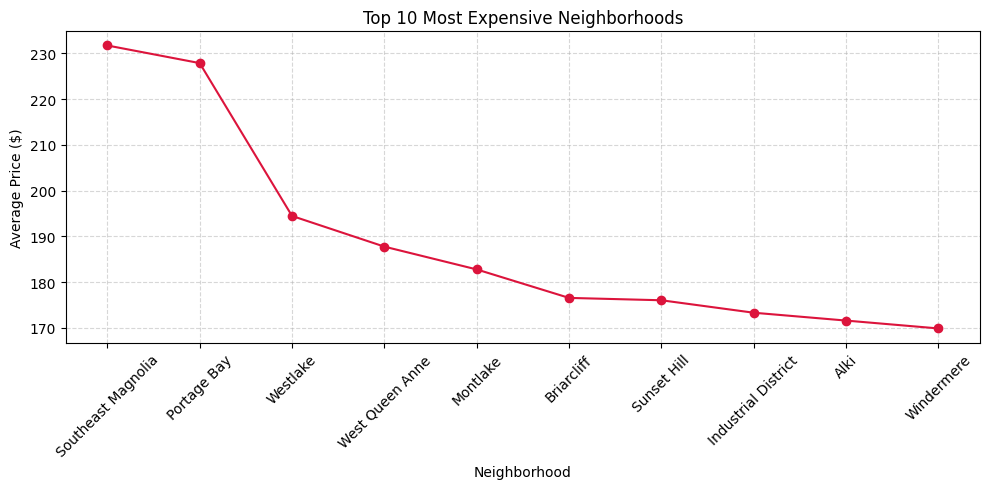

In [19]:
# Top 10 neighborhoods by average price

top10_neigh = df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.plot(top10_neigh.index, top10_neigh.values, marker='o', linestyle='-', color='crimson')
plt.title("Top 10 Most Expensive Neighborhoods")
plt.xlabel("Neighborhood")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 2. What types of properties are most common?

This horizontal bar chart shows the most frequently listed property types on Airbnb.

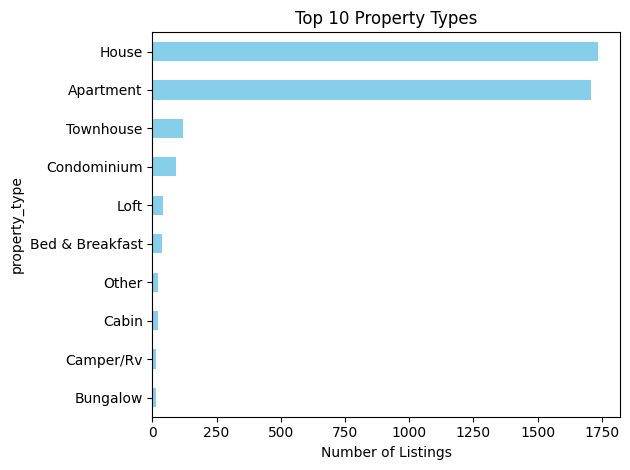

In [20]:
# Distribution of property types

df['property_type'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Property Types")
plt.xlabel("Number of Listings")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3. How does room type affect price?

Room type has a clear impact on pricing. Entire homes generally cost more than private or shared rooms.


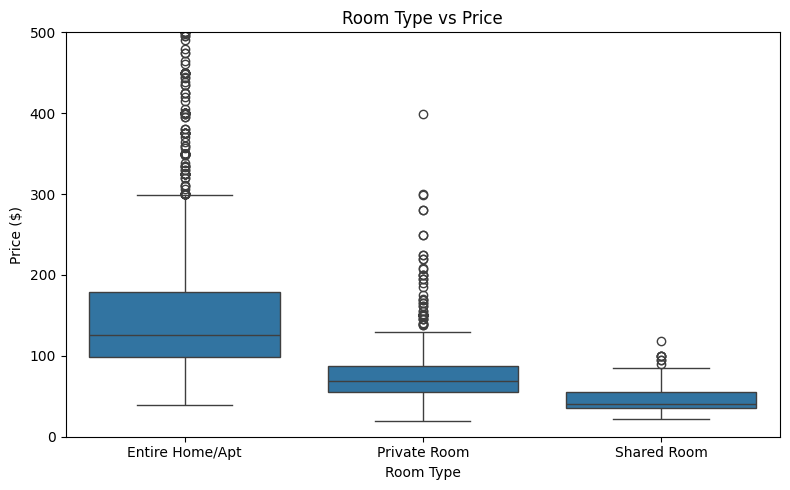

In [21]:
# Boxplot: Room Type vs Price

plt.figure(figsize=(8, 5))
sns.boxplot(x='room_type', y='price', data=df)
sns.set_palette("Set2")
plt.title("Room Type vs Price")
plt.ylabel("Price ($)")
plt.xlabel("Room Type")
plt.ylim(0, 500)
plt.tight_layout()
plt.show()


### 4. Is there a relationship between review scores and price?

This scatter plot explores whether highly rated listings tend to charge more. The correlation appears weak.

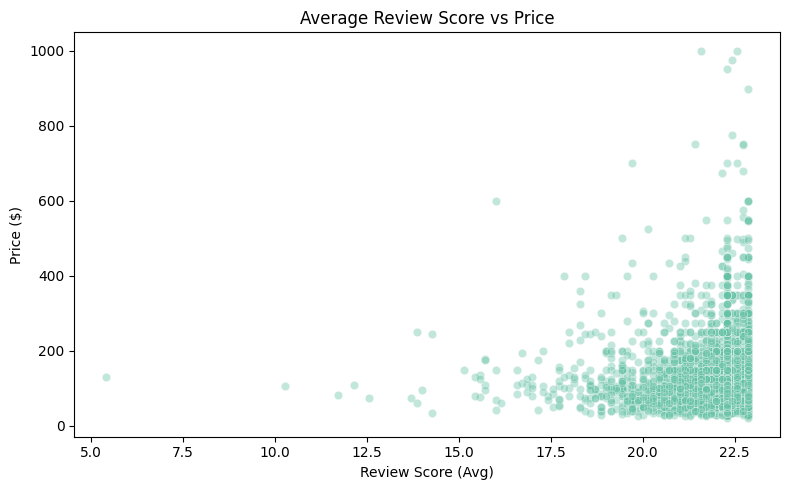

In [22]:
# Scatter plot: Average Review Score vs Price

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='review_score_avg', y='price', alpha=0.4)
sns.set_palette("viridis")
plt.title("Average Review Score vs Price")
plt.xlabel("Review Score (Avg)")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

### 5. Which hosts have the most listings?

Some hosts manage a large number of listings, likely commercial Airbnb operators.

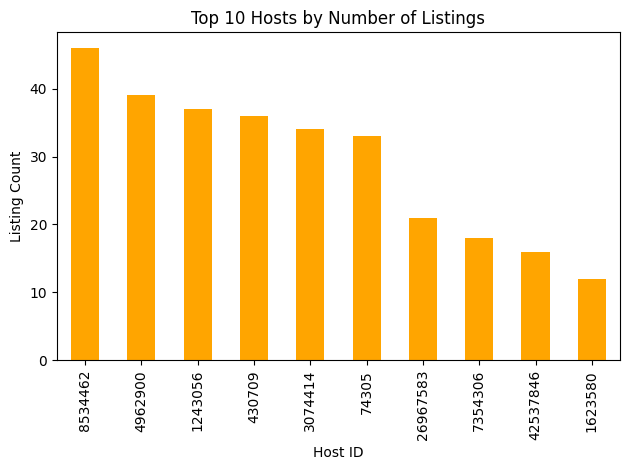

In [23]:
# Top 10 hosts by listing count

top_hosts = df['host_id'].value_counts().head(10)
top_hosts.plot(kind='bar', color='orange')
plt.title("Top 10 Hosts by Number of Listings")
plt.xlabel("Host ID")
plt.ylabel("Listing Count")
plt.tight_layout()
plt.show()

### 6. What is the availability of listings across neighborhoods?

This chart shows neighborhoods with the most days available per year.

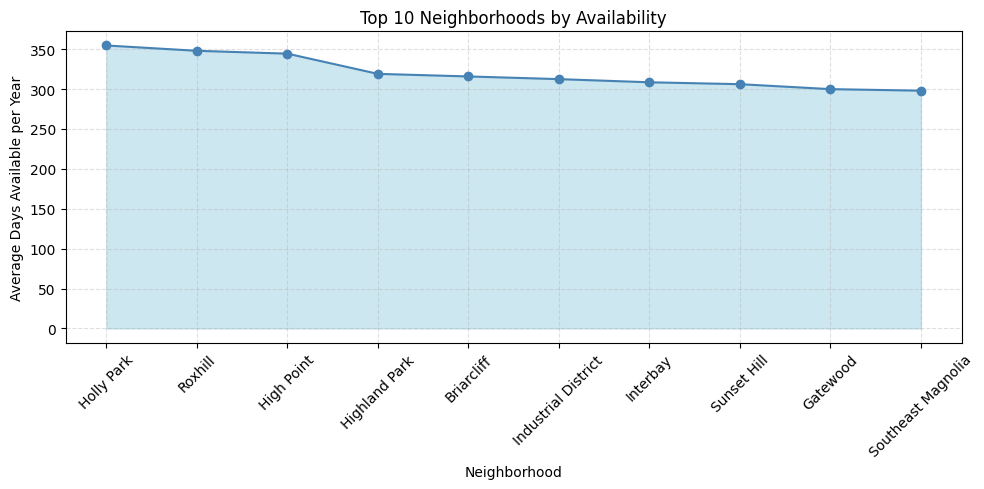

In [24]:
# Top 10 neighborhoods by average availability

top_avail = df.groupby('neighbourhood_cleansed')['availability_365'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.fill_between(top_avail.index, top_avail.values, color='lightblue', alpha=0.6)
plt.plot(top_avail.index, top_avail.values, color='steelblue', marker='o')
plt.title("Top 10 Neighborhoods by Availability")
plt.xlabel("Neighborhood")
plt.ylabel("Average Days Available per Year")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 7. How does cancellation policy affect pricing?

Listings with flexible or moderate cancellation policies tend to charge less than strict ones.

C:\Users\anujm\AppData\Local\Temp\ipykernel_32800\4078733716.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='cancellation_policy', y='price', palette='Set2')


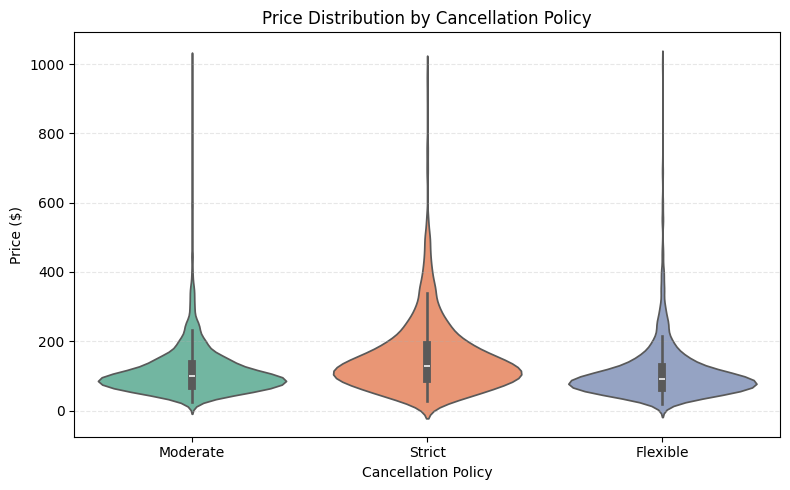

In [25]:
# Bar chart: Avg price per cancellation policy

plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='cancellation_policy', y='price', palette='Set2')
plt.title("Price Distribution by Cancellation Policy")
plt.xlabel("Cancellation Policy")
plt.ylabel("Price ($)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 8. How does the number of reviews relate to price?

No strong trend observed — high price doesn’t guarantee more reviews.

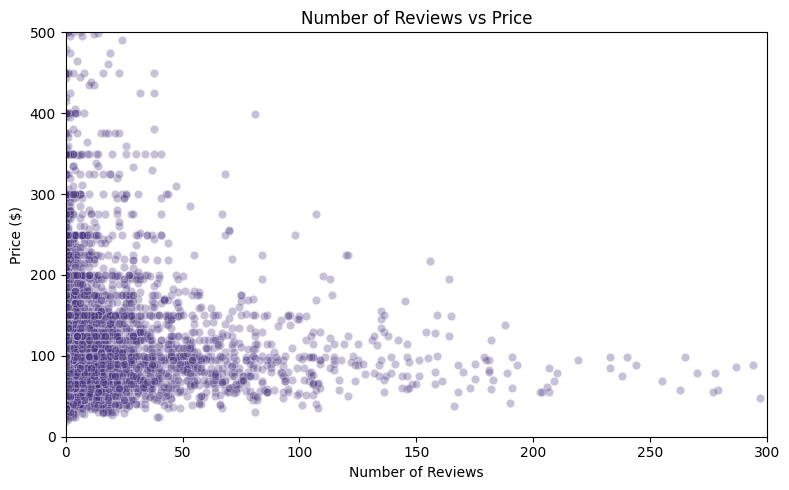

In [26]:
# Scatter: Number of Reviews vs Price

plt.figure(figsize=(8,5))
sns.scatterplot(x='number_of_reviews', y='price', data=df, alpha=0.3)
sns.set_palette("viridis")
plt.title("Number of Reviews vs Price")
plt.xlabel("Number of Reviews")
plt.ylabel("Price ($)")
plt.xlim(0, 300)
plt.ylim(0, 500)
plt.tight_layout()
plt.show()

### 9. Which listings are most popular based on reviews per month?

This chart highlights listings with the highest monthly review rates — a proxy for popularity.

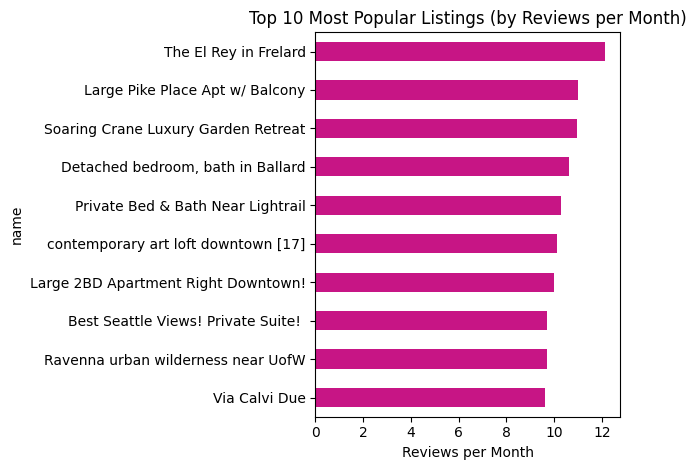

In [27]:
# Top 10 listings by reviews/month

top_popular = df[['name', 'reviews_per_month']].sort_values(by='reviews_per_month', ascending=False).head(10)
top_popular.set_index('name')['reviews_per_month'].plot(kind='barh', color='mediumvioletred')
plt.title("Top 10 Most Popular Listings (by Reviews per Month)")
plt.xlabel("Reviews per Month")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 10. What’s the correlation between key numeric variables?

This heatmap reveals relationships between price, reviews, availability, and listing size.

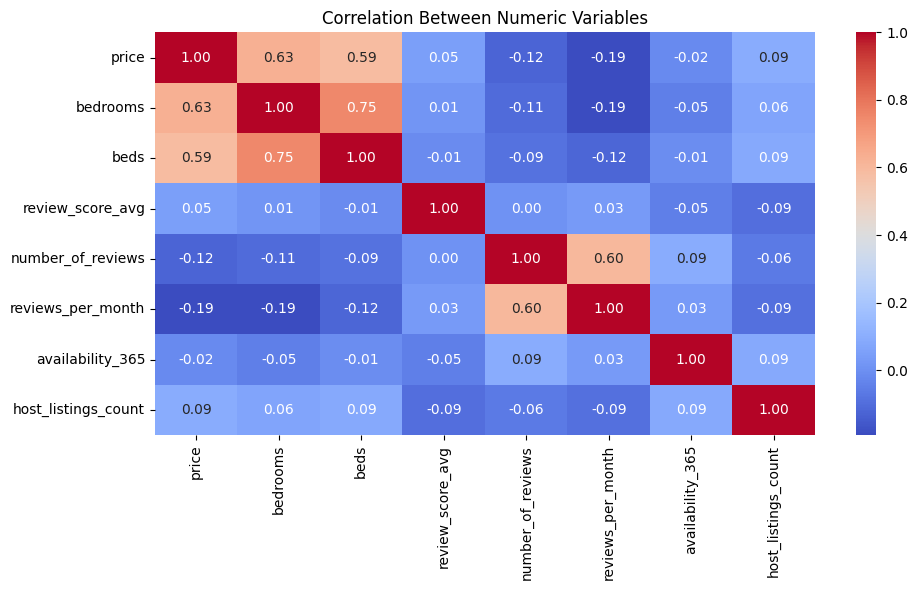

In [28]:
# Heatmap of correlations

# Choose relevant numeric columns
corr_cols = ['price', 'bedrooms', 'beds', 'review_score_avg', 'number_of_reviews',
             'reviews_per_month', 'availability_365', 'host_listings_count']

plt.figure(figsize=(10,6))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Variables")
plt.tight_layout()
plt.show()


Extra Visulizaion
Word Cloud of Listing Descriptions

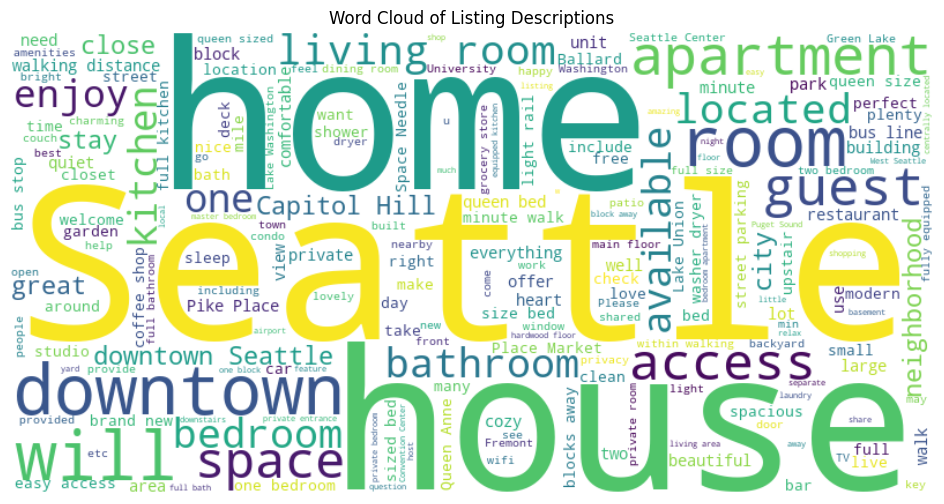

In [29]:
text = ' '.join(df['description'].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Listing Descriptions")
plt.show()
